# Курсовой проект по курсу Спортивный анализ данных. Платформа Kaggle

In [53]:
from typing import List,Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

import missingno as msno

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm
from typing import List, Tuple

In [2]:
DATA_PATH="Data"
def load_data(dataset_name,data_path=DATA_PATH):
    csv_path = os.path.join(data_path,dataset_name)
    data = pd.read_csv(csv_path)
    data.columns=[col.upper() for col in data.columns]
    print("shape = {} rows, {} cols".format(*data.shape))
    return data

In [3]:
train = load_data("train.csv")
test = load_data("test.csv")
client_profile=load_data("client_profile.csv")
#applications_history=load_data("applications_history.csv")
#bki=load_data("bki.csv")
#payments=load_data("payments.csv")

shape = 110093 rows, 3 cols
shape = 165141 rows, 2 cols
shape = 250000 rows, 24 cols


In [4]:
train.describe()

,APPLICATION_NUMBER,TARGET
count,1.100930e+05,110093.000000
mean,1.235772e+08,0.080813
std,8.880939e+04,0.272550
min,1.234233e+08,0.000000
25%,1.235005e+08,0.000000
50%,1.235769e+08,0.000000
75%,1.236539e+08,0.000000
max,1.237308e+08,1.000000


In [5]:
train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash
...,...,...,...
110088,123458312,0,Cash
110089,123672463,0,Cash
110090,123723001,0,Cash
110091,123554358,0,Cash


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
APPLICATION_NUMBER    110093 non-null int64
TARGET                110093 non-null int64
NAME_CONTRACT_TYPE    110093 non-null object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [7]:
train["APPLICATION_NUMBER"].nunique()

110093

In [8]:
test

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash
...,...,...
165136,123487967,Cash
165137,123536402,Cash
165138,123718238,Cash
165139,123631557,Cash


**Выводы - поле APPLICATION_NUMBER - просто идентификатор типа ID, который нужен лишь для соединения с другими датасетами**

In [9]:
def target_description_print(ds, target_name):                              
    """
    Печать распределения целевых значений.
    
    Parameters
    ----------
    ds: pd.DataFrame
        Вектор целевой переменной.
    target_name: str
        название целевого поля
    """
    
    values_count_TARGET_0 = ds[ds[target_name]==0].count()[target_name]
    values_count_TARGET_1 = ds[ds[target_name]==1].count()[target_name]
    values_count_TARGET_1_2 = np.around(values_count_TARGET_1/values_count_TARGET_0,3)
    values_count_TARGET_Sum = values_count_TARGET_0+values_count_TARGET_1
    print("TARGET==0 values count =",values_count_TARGET_0)
    print("TARGET==1 values count =",values_count_TARGET_1)
    print("(TARGET==1)count / (TARGET==0)count =",values_count_TARGET_1_2)
    print("TARGET==0 and TARGET==1 in sum values count =",values_count_TARGET_Sum)

In [10]:
target_description_print(train,'TARGET')

TARGET==0 values count = 101196
TARGET==1 values count = 8897
(TARGET==1)count / (TARGET==0)count = 0.088
TARGET==0 and TARGET==1 in sum values count = 110093


#### Создание модели с вновь построенными признаками версия 4

Анализ распределения признаков client_profile

In [11]:
def show_features_distribution(ds, numerical_features, n_rows, n_cols, isTrain, isPlot=True):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    title=''
    if isTrain:
        title = 'train'
    else:
        title = 'test'
    print('Features distribution for {}'.format(title))

    for num, feature in enumerate(numerical_features):
        data = ds[feature].copy()    
        if n_rows==1 and n_cols==1:            
            if isPlot:
                plt.plot(data, color="blue")
            else:
                plt.hist(data,bins=1000, color="blue")
            plt.xlabel(feature, fontsize=12)
        else:            
            if isPlot:
                axes[num%n_rows, num//n_rows].plot(data, color="blue")
            else:
                axes[num%n_rows, num//n_rows].hist(data, bins=1000, color="blue")
            axes[num%n_rows, num//n_rows].set_xlabel(feature, fontsize=12)

In [12]:
numerical_features = client_profile.select_dtypes(exclude=["object"])
numerical_features=numerical_features.drop(["APPLICATION_NUMBER"],axis=1)

In [13]:
numerical_features.describe()

,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,250000.000000,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,0.057072,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,0.231981,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,0.000000,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,0.000000,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,0.000000,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,1.000000,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [14]:
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 20 columns):
CHILDRENS                     250000 non-null int64
TOTAL_SALARY                  250000 non-null float64
AMOUNT_CREDIT                 250000 non-null float64
AMOUNT_ANNUITY                249989 non-null float64
REGION_POPULATION             250000 non-null float64
AGE                           250000 non-null int64
DAYS_ON_LAST_JOB              250000 non-null int64
OWN_CAR_AGE                   85041 non-null float64
FLAG_PHONE                    250000 non-null int64
FLAG_EMAIL                    250000 non-null int64
FAMILY_SIZE                   249998 non-null float64
EXTERNAL_SCORING_RATING_1     109121 non-null float64
EXTERNAL_SCORING_RATING_2     249468 non-null float64
EXTERNAL_SCORING_RATING_3     200462 non-null float64
AMT_REQ_CREDIT_BUREAU_HOUR    216293 non-null float64
AMT_REQ_CREDIT_BUREAU_DAY     216293 non-null float64
AMT_REQ_CREDIT_BUREAU_WEEK    216293

In [15]:
tmp=pd.DataFrame(data=numerical_features, columns=['DAYS_ON_LAST_JOB','OWN_CAR_AGE','AMT_REQ_CREDIT_BUREAU_QRT'])

Features distribution for train


C:\Users\Windows\.conda\envs\tf\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Windows\.conda\envs\tf\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


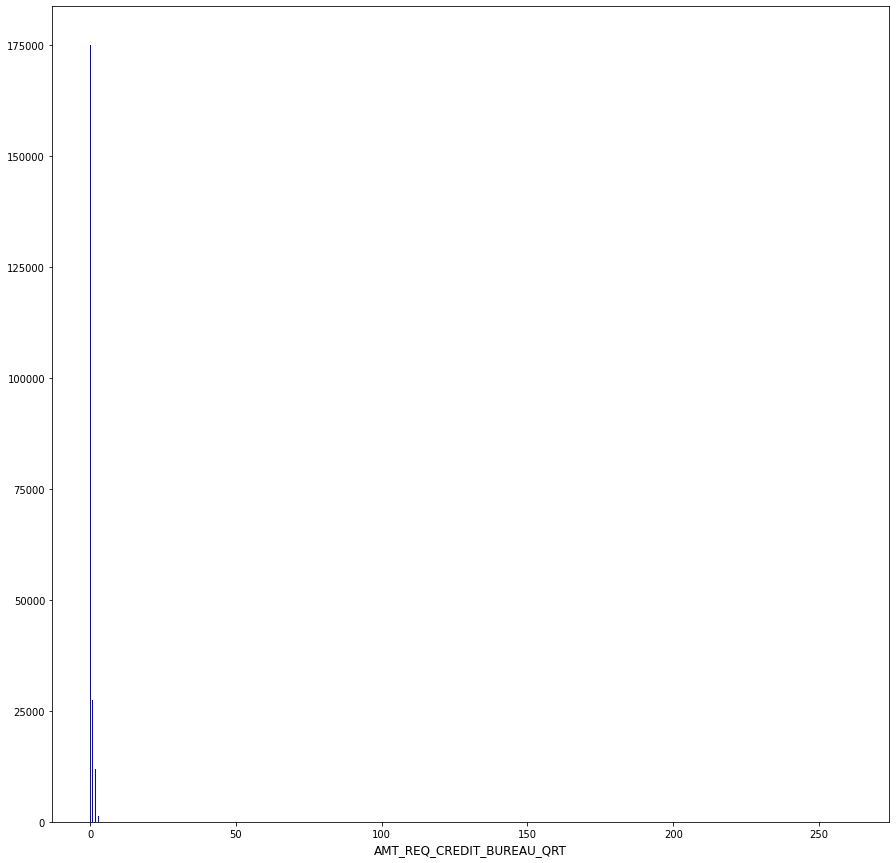

In [16]:
n_cols = 1
n_rows = 1 #len(tmp)//n_cols + 1
show_features_distribution(tmp,['AMT_REQ_CREDIT_BUREAU_QRT'],n_rows, n_cols, isTrain=True, isPlot=False)

In [17]:
numerical_features[numerical_features['AMT_REQ_CREDIT_BUREAU_QRT']>10]['AMT_REQ_CREDIT_BUREAU_QRT'].count()

2

Features distribution for train


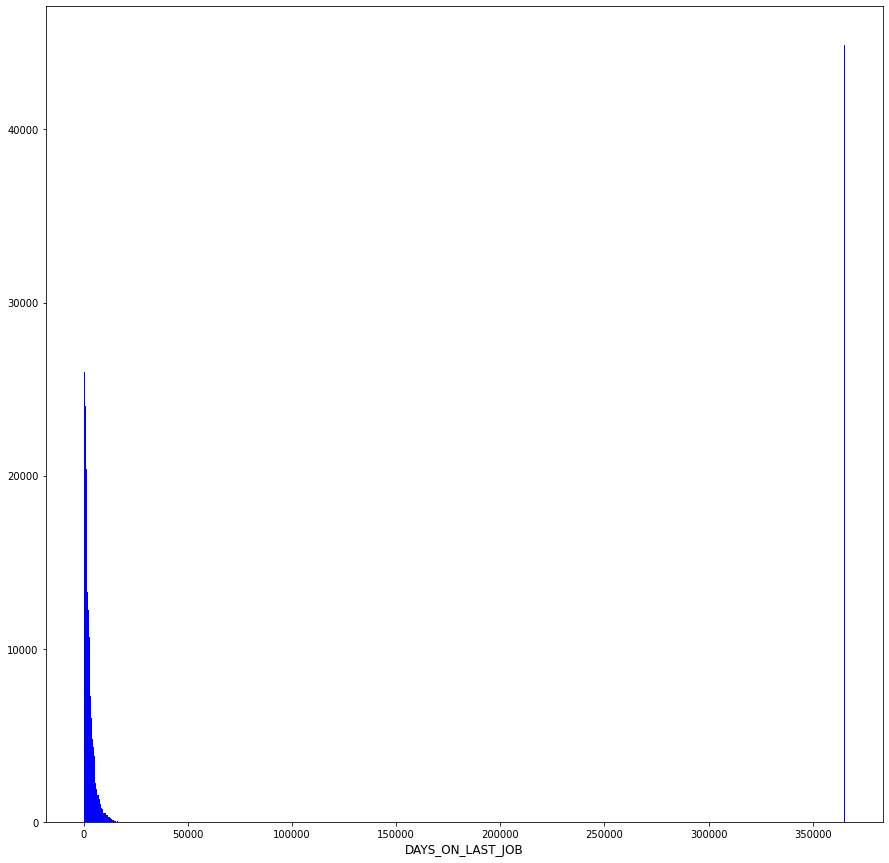

In [18]:
n_cols = 1
n_rows = 1 #len(tmp)//n_cols + 1
show_features_distribution(tmp,['DAYS_ON_LAST_JOB'],n_rows, n_cols, isTrain=True, isPlot=False)

In [19]:
dayes_in_year=365
max_job_duration_years=70

In [20]:
numerical_features[numerical_features['DAYS_ON_LAST_JOB']>dayes_in_year*max_job_duration_years]['DAYS_ON_LAST_JOB'].count()

44867

для DAYS_ON_LAST_JOB и AMT_REQ_CREDIT_BUREAU_QRT - надо удалить выбросы

In [21]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    result = result[result["Total"] != 0]
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [22]:
client_profile_missing = check_missings(client_profile)
client_profile_missing

Total NA-values = 558163


,AMOUNT_ANNUITY,OWN_CAR_AGE,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
Total,11,164959,2,140879,532,49538,33707,33707,33707,33707,33707,33707
Percent,0.0044,65.9836,0.0008,56.3516,0.2128,19.8152,13.4828,13.4828,13.4828,13.4828,13.4828,13.4828
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [23]:
from sklearn.impute import KNNImputer

In [24]:
knn_imputer = KNNImputer(n_neighbors=25, weights="uniform")
client_profile["AMOUNT_ANNUITY"] = knn_imputer.fit_transform(client_profile[["AMOUNT_ANNUITY"]])
client_profile["FAMILY_SIZE"] = knn_imputer.fit_transform(client_profile[["FAMILY_SIZE"]])
client_profile["EXTERNAL_SCORING_RATING_2"] = knn_imputer.fit_transform(client_profile[["EXTERNAL_SCORING_RATING_2"]])

In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [26]:
iterative_imputer = IterativeImputer()
client_profile[numerical_features.columns] = iterative_imputer.fit_transform(client_profile[numerical_features.columns])


In [27]:
client_profile_missing = check_missings(client_profile)
client_profile_missing

Total NA-values = 0


""
Total
Percent
Types


In [28]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          cat_feats,
                          metric: callable,                          
                          cv_strategy,                          
                          isCatBoost=False
                          ):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        if isCatBoost:
            estimator.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
                          cat_features=cat_feats,plot=True)
        else:
            estimator.fit(X=x_train,y=y_train,
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      early_stopping_rounds=500,
                      eval_metric="auc",
                      verbose=200,
                      categorical_feature=cat_feats)
        
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        
        oof_predictions[valid_idx] = y_valid_pred        
        oof_predictions[train_idx] = y_train_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [29]:
def create_client_profile_features(X:pd.DataFrame, copy:bool=True)->pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов
    
    Parameters
    ----------
    X: pd.DataFrame
            исходная матрица признаков с профилем клиента
    copy:bool,optional
            использовать ли копию DF X, по умолчанию=True
    
    Returns 
    -------
    X_transformed:pd.DataFrame
            расширенная матрица признаков с профилем клиента
        
    """
    if copy:
        X=X.copy(deep=True)
        
        
    #AMT_REQ_CREDIT_BUREAU_QRT_max=10
    #X['AMT_REQ_CREDIT_BUREAU_QRT']=np.where(X['AMT_REQ_CREDIT_BUREAU_QRT'] < AMT_REQ_CREDIT_BUREAU_QRT_max,
    #                                        X['AMT_REQ_CREDIT_BUREAU_QRT'],np.nan)
    
    dayes_in_year=365
    max_job_duration_years=70 #предполагаем что макс время работы не более 70 лет
    X['DAYS_ON_LAST_JOB']= np.where(X['DAYS_ON_LAST_JOB'] < dayes_in_year * max_job_duration_years,
                                    X['DAYS_ON_LAST_JOB'],np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["BKI_REQUESTS_COUNT"] = X[bki_flags].sum(axis=1)
    X["BKI_KURTOSIS"] = X[bki_flags].kurtosis(axis=1)
    X["EXTERNAL_SCORING_PROD"] = X["EXTERNAL_SCORING_RATING_1"] * X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    
    total_ext_scoring_ratings = X["EXTERNAL_SCORING_RATING_1"].sum()+X["EXTERNAL_SCORING_RATING_2"].sum()+X["EXTERNAL_SCORING_RATING_3"].sum()
    ext_scoring_rating_1_ratio=np.ceil((total_ext_scoring_ratings / 3) / client_profile['EXTERNAL_SCORING_RATING_1'].sum())
    ext_scoring_rating_2_ratio=np.ceil((total_ext_scoring_ratings / 3) / client_profile['EXTERNAL_SCORING_RATING_2'].sum())
    ext_scoring_rating_3_ratio=np.ceil((total_ext_scoring_ratings / 3) / client_profile['EXTERNAL_SCORING_RATING_3'].sum())
    X["EXTERNAL_SCORING_WEIGHTED"] = X["EXTERNAL_SCORING_RATING_1"] * ext_scoring_rating_1_ratio + X["EXTERNAL_SCORING_RATING_2"] * ext_scoring_rating_2_ratio + X["EXTERNAL_SCORING_RATING_3"] * ext_scoring_rating_3_ratio

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1","EXTERNAL_SCORING_RATING_2","EXTERNAL_SCORING_RATING_3"]],axis=1)
        
    #Отношение между основными фин. показателями
    X["RATIO_CREDIT_TO_ANNUITY"] = X["AMOUNT_CREDIT"] / X["AMOUNT_ANNUITY"]
    X["RATIO_ANNUITY_TO_SALARY"] = X["AMOUNT_ANNUITY"] / X["TOTAL_SALARY"]
    X["RATIO_CREDIT_TO_SALARY"] = X["AMOUNT_CREDIT"] / X["TOTAL_SALARY"]
    X["TOTAL_SALARY_NET"] = X["TOTAL_SALARY"]-X["AMOUNT_ANNUITY"]
    
    #Отношение фин. показателей к возрасту и врем признакам
    X["RATIO_ANNUITY_TO_AGE"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["RATIO_CREDIT_TO_AGE"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["RATIO_SALARY_TO_AGE"] = X["TOTAL_SALARY"] / X["AGE"]
    X["RATIO_ANNUITY_TO_EXPERIENCE"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CREDIT_TO_EXPERIENCE"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_EXPERIENCE"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]

    #Отношение временных признаков
    X["RATIO_AGE_TO_EXPERIENCE"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_REGION_POPULATION"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]    
    X["RATIO_CAR_TO_EXPERIENCE"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]    
    X["RATIO_CAR_TO_AGE"] = X["OWN_CAR_AGE"] / X["AGE"]

    #Произведение фин. показателей кредита на вероятность дефолта (мат ожидание дефолта или ожидаемые потери)
    X["EXPECTED_TOTAL_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_MONTHLY_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]

    #м.б закометарены
    
    
    
    X["EXTERNAL_SCORING_RATING_1_PLUS_2"]=np.nansum(
        X[["EXTERNAL_SCORING_RATING_1","EXTERNAL_SCORING_RATING_2"]], axis=1
    )
    X["EXTERNAL_SCORING_RATING_1_PLUS_3"]=np.nansum(
        X[["EXTERNAL_SCORING_RATING_1","EXTERNAL_SCORING_RATING_3"]], axis=1
    )
    
    X["EXTERNAL_SCORING_RATING_2_PLUS_3"]=np.nansum(
        X[["EXTERNAL_SCORING_RATING_2","EXTERNAL_SCORING_RATING_3"]], axis=1
    )
    
    
    
    X["EXTERNAL_SCORING_RATING_1_IS_NAN"]=np.isnan(X["EXTERNAL_SCORING_RATING_1"])
    X["EXTERNAL_SCORING_RATING_2_IS_NAN"]=np.isnan(X["EXTERNAL_SCORING_RATING_2"])
    X["EXTERNAL_SCORING_RATING_3_IS_NAN"]=np.isnan(X["EXTERNAL_SCORING_RATING_3"])
    
    """
    """

    #доп признаки
    X["RATIO_CREDIT_PER_FAMILY_SIZE"] = X["AMOUNT_CREDIT"] / X["FAMILY_SIZE"]
    X["RATIO_CREDIT_PER_CHILDRENS"] = X["AMOUNT_CREDIT"] / (1+X["CHILDRENS"])
    X["RATIO_CHILDRENS_TO_FAMILY_SIZE"] = X["CHILDRENS"] / X["FAMILY_SIZE"]
    X["RATIO_SALARY_PER_FAMILY_SIZE"] = X["TOTAL_SALARY"] / X["FAMILY_SIZE"]
    X["RATIO_SALARY_PER_CHILD"] = X["TOTAL_SALARY"] / X["CHILDRENS"]    
    X["NON_CHILD"] = X["FAMILY_SIZE"] - X["CHILDRENS"]    
    X["RATIO_CHILD_TO_NON_CHILD"] = X["CHILDRENS"] / X["NON_CHILD"]    
    X["RATIO_SALARY_PER_NON_CHILD"] = X["TOTAL_SALARY"] / X["NON_CHILD"]
    X["RATIO_CREDIT_PER_NON_CHILD"] = X["AMOUNT_CREDIT"] / X["NON_CHILD"]
    
    
    
    

    return X
    

In [30]:
client_profile.columns

Index(['APPLICATION_NUMBER', 'GENDER', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'EDUCATION_LEVEL', 'FAMILY_STATUS',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [31]:
client_profile

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0.0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560.0,...,2.0,0.329471,0.236315,0.678568,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
1,123423688,F,0.0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187.0,...,2.0,0.758282,0.442295,0.802745,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2,123501780,M,1.0,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387.0,...,3.0,0.409017,0.738159,0.491579,0.006862,0.006286,0.034368,0.459342,0.241681,1.972518
3,123588799,M,0.0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273.0,...,2.0,0.450509,0.308994,0.590233,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
4,123647485,M,0.0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954.0,...,2.0,0.723691,0.739408,0.156640,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,123657254,M,0.0,216000.0,45000.0,2425.5,Higher education,Married,0.018850,19150.0,...,2.0,0.555436,0.581592,0.048259,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
249996,123645397,M,0.0,103500.0,675000.0,28507.5,Higher education,Married,0.014520,19604.0,...,2.0,0.685357,0.676409,0.726711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
249997,123504053,M,0.0,202500.0,1078200.0,38331.0,Secondary / secondary special,Single / not married,0.031329,8351.0,...,1.0,0.269227,0.353665,0.283712,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
249998,123547316,F,0.0,135000.0,500211.0,38839.5,Secondary / secondary special,Married,0.030755,13277.0,...,2.0,0.305746,0.682462,0.639708,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [32]:
data=pd.concat([train,test],axis=0)
data = data.reset_index(drop=True)

C:\Users\Windows\AppData\Local\Temp/ipykernel_11268/2666864051.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data=pd.concat([train,test],axis=0)


In [33]:
client_profile=create_client_profile_features(client_profile)

In [34]:
data=data.merge(client_profile, how="left", on="APPLICATION_NUMBER")

In [35]:
data.shape

(275234, 70)

In [36]:
def get_splitted_data(data:pd.DataFrame, target_name:str, join_feature_name:str):
                       
    """
    Получить разбивку на train, test, target, test_id, categorical,numerical

    Parameters
    ----------
    data: pd.DataFrame
        Матрица признаков общаяя.
   
    target_name: str
        имя поля целевого признака
    
    join_feature_name: str
        имя поля признака по которому будем соединять тест


    Returns
    -------
    train: pd.DataFrame
        Полная часть - вся учебная выборка.

    test: pd.DataFrame
        Полная часть - вся тестовая выборка.
        
    target:pd.core.series.Series
        значение целевой переменной
        
    test_id:pd.core.series.Series
        значение признака по которому будем соединять тест
    
    categorical: list
        Список имен полей категориальных признаков
    
    numerical: list
        Список имен полей числовых признаков
    
        
    """
    
    mask=data[target_name].isnull()
    feature_to_drop=[join_feature_name,target_name]

    train,test=data.loc[~mask],data.loc[mask]

    target,test_id=train[target_name],test[join_feature_name]
    train=train.drop(feature_to_drop,axis=1)
    test=test.drop(feature_to_drop,axis=1)

    categorical = train.dtypes[train.dtypes=="object"].index.tolist()
    numerical=list(set(train.columns)-set(categorical))

    train=train.replace(np.inf,np.nan)
    train=train.replace(-np.inf,np.nan)
    
    return train, test, target, test_id, categorical,numerical

In [37]:
train, test, target, test_id, categorical,numerical = get_splitted_data(
    data, target_name="TARGET", join_feature_name="APPLICATION_NUMBER")

In [230]:
lgbm_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 7,
    "seed": 27,
    "early_stopping_rounds":500,
    'num_leaves': 57,
    'max_depth': 8,
    'subsample_for_bin': 200000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
}

In [39]:
train[categorical]=train[categorical].fillna('NA')
test[categorical]=test[categorical].fillna('NA')

In [40]:
for c in categorical:
    train[c] = train[c].astype('category')
for c in categorical:
    test[c] = test[c].astype('category')

In [54]:
 model = lgb.LGBMClassifier(**lgbm_params)

In [55]:
#model,test_prediction=get_samples_hold_out_validation(lgbm_params,train,target,[0.7,0.2,0.1],'LGBM', categorical)
#cv_strategy = KFold(n_splits=20, random_state=42,shuffle=True)
#cv_strategy = StratifiedShuffleSplit(n_splits=20, random_state=29, train_size=0.7)
cv_strategy = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model, categorical, metric=roc_auc_score,cv_strategy=cv_strategy
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.763778	valid_1's auc: 0.714125
[400]	training's auc: 0.794745	valid_1's auc: 0.720975
[600]	training's auc: 0.818907	valid_1's auc: 0.724648
[800]	training's auc: 0.83728	valid_1's auc: 0.724385
[1000]	training's auc: 0.853685	valid_1's auc: 0.724267
Fold: 1, train-observations = 104588, valid-observations = 5505
train-score = 0.8205, valid-score = 0.7253
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.76439	valid_1's auc: 0.708987
[400]	training's auc: 0.795177	valid_1's auc: 0.720182
[600]	training's auc: 0.819345	valid_1's auc: 0.722238
[800]	training's auc: 0.838071	valid_1's auc: 0.721496
[1000]	training's auc: 0.853672	valid_1's auc: 0.721613
[1200]	training's auc: 0.868552	valid_1's auc: 0.721556
[1400]	training's auc: 0.882609	valid_1's auc: 0.720887
Fold: 2, train-observations = 104588, valid-observations = 5505
train-score = 0.8556, valid-score = 0.7227
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764518	valid_1's auc: 0.729777
[400]	training's auc: 0.795023	valid_1's auc: 0.728227
[600]	training's auc: 0.817831	valid_1's auc: 0.728307
Fold: 3, train-observations = 104588, valid-observations = 5505
train-score = 0.7645, valid-score = 0.7298
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763873	valid_1's auc: 0.722738
[400]	training's auc: 0.794693	valid_1's auc: 0.7308
[600]	training's auc: 0.818078	valid_1's auc: 0.732849
[800]	training's auc: 0.836817	valid_1's auc: 0.732825
[1000]	training's auc: 0.852839	valid_1's auc: 0.734248
[1200]	training's auc: 0.866708	valid_1's auc: 0.733525
[1400]	training's auc: 0.879059	valid_1's auc: 0.73404
Fold: 4, train-observations = 104588, valid-observations = 5505
train-score = 0.8578, valid-score = 0.735
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763852	valid_1's auc: 0.721292
[400]	training's auc: 0.795315	valid_1's auc: 0.727147
[600]	training's auc: 0.820651	valid_1's auc: 0.728892
[800]	training's auc: 0.840483	valid_1's auc: 0.730595
[1000]	training's auc: 0.857289	valid_1's auc: 0.732093
[1200]	training's auc: 0.871711	valid_1's auc: 0.732016
[1400]	training's auc: 0.884016	valid_1's auc: 0.729525
Fold: 5, train-observations = 104588, valid-observations = 5505
train-score = 0.8624, valid-score = 0.7332
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763932	valid_1's auc: 0.720072
[400]	training's auc: 0.794204	valid_1's auc: 0.724287
[600]	training's auc: 0.817141	valid_1's auc: 0.725402
[800]	training's auc: 0.835235	valid_1's auc: 0.72458
[1000]	training's auc: 0.851741	valid_1's auc: 0.723413
Fold: 6, train-observations = 104588, valid-observations = 5505
train-score = 0.8216, valid-score = 0.7257
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.76329	valid_1's auc: 0.728688
[400]	training's auc: 0.794275	valid_1's auc: 0.733198
[600]	training's auc: 0.817262	valid_1's auc: 0.737553
[800]	training's auc: 0.835705	valid_1's auc: 0.737476
[1000]	training's auc: 0.85208	valid_1's auc: 0.740141
[1200]	training's auc: 0.866924	valid_1's auc: 0.741652
[1400]	training's auc: 0.880361	valid_1's auc: 0.741741
[1600]	training's auc: 0.890674	valid_1's auc: 0.742276
[1800]	training's auc: 0.900122	valid_1's auc: 0.741509
[2000]	training's auc: 0.908849	valid_1's auc: 0.743262
[2200]	training's auc: 0.916071	valid_1's auc: 0.7429
[2400]	training's auc: 0.921747	valid_1's auc: 0.742688
Fold: 7, train-observations = 104588, valid-observations = 5505
train-score = 0.9095, valid-score = 0.7443
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.762998	valid_1's auc: 0.73328
[400]	training's auc: 0.794124	valid_1's auc: 0.741468
[600]	training's auc: 0.816972	valid_1's auc: 0.741595
[800]	training's auc: 0.836158	valid_1's auc: 0.74399
[1000]	training's auc: 0.852434	valid_1's auc: 0.740913
[1200]	training's auc: 0.866914	valid_1's auc: 0.741101
Fold: 8, train-observations = 104588, valid-observations = 5505
train-score = 0.8375, valid-score = 0.7441
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763938	valid_1's auc: 0.72068
[400]	training's auc: 0.793707	valid_1's auc: 0.726561
[600]	training's auc: 0.815615	valid_1's auc: 0.727318
[800]	training's auc: 0.834231	valid_1's auc: 0.728993
[1000]	training's auc: 0.852016	valid_1's auc: 0.72898
[1200]	training's auc: 0.86626	valid_1's auc: 0.726883
Fold: 9, train-observations = 104588, valid-observations = 5505
train-score = 0.8415, valid-score = 0.7295
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764002	valid_1's auc: 0.730111
[400]	training's auc: 0.794596	valid_1's auc: 0.736568
[600]	training's auc: 0.818201	valid_1's auc: 0.739867
[800]	training's auc: 0.836942	valid_1's auc: 0.740072
[1000]	training's auc: 0.853161	valid_1's auc: 0.741826
[1200]	training's auc: 0.867109	valid_1's auc: 0.740639
[1400]	training's auc: 0.879673	valid_1's auc: 0.739896
Fold: 10, train-observations = 104588, valid-observations = 5505
train-score = 0.8548, valid-score = 0.7425
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764785	valid_1's auc: 0.721964
[400]	training's auc: 0.795107	valid_1's auc: 0.727716
[600]	training's auc: 0.817184	valid_1's auc: 0.726458
[800]	training's auc: 0.836113	valid_1's auc: 0.725879
Fold: 11, train-observations = 104588, valid-observations = 5505
train-score = 0.801, valid-score = 0.7282
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764744	valid_1's auc: 0.719204
[400]	training's auc: 0.79578	valid_1's auc: 0.721826
[600]	training's auc: 0.818977	valid_1's auc: 0.721934
[800]	training's auc: 0.837052	valid_1's auc: 0.721843
Fold: 12, train-observations = 104588, valid-observations = 5505
train-score = 0.7998, valid-score = 0.7229
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763782	valid_1's auc: 0.731396
[400]	training's auc: 0.794913	valid_1's auc: 0.737393
[600]	training's auc: 0.81815	valid_1's auc: 0.739398
[800]	training's auc: 0.836453	valid_1's auc: 0.739168
Fold: 13, train-observations = 104588, valid-observations = 5505
train-score = 0.8061, valid-score = 0.7397
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764443	valid_1's auc: 0.704685
[400]	training's auc: 0.795315	valid_1's auc: 0.712086
[600]	training's auc: 0.817038	valid_1's auc: 0.714168
[800]	training's auc: 0.835832	valid_1's auc: 0.715223
[1000]	training's auc: 0.852977	valid_1's auc: 0.71634
[1200]	training's auc: 0.86774	valid_1's auc: 0.716561
[1400]	training's auc: 0.880269	valid_1's auc: 0.71686
[1600]	training's auc: 0.891082	valid_1's auc: 0.716548
[1800]	training's auc: 0.900625	valid_1's auc: 0.716913
Fold: 14, train-observations = 104589, valid-observations = 5504
train-score = 0.8843, valid-score = 0.7176
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764421	valid_1's auc: 0.718802
[400]	training's auc: 0.794747	valid_1's auc: 0.72738
[600]	training's auc: 0.818064	valid_1's auc: 0.728256
[800]	training's auc: 0.836061	valid_1's auc: 0.727158
[1000]	training's auc: 0.852746	valid_1's auc: 0.726912
Fold: 15, train-observations = 104589, valid-observations = 5504
train-score = 0.8111, valid-score = 0.7291
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.765157	valid_1's auc: 0.695209
[400]	training's auc: 0.795542	valid_1's auc: 0.702692
[600]	training's auc: 0.818772	valid_1's auc: 0.70346
[800]	training's auc: 0.837361	valid_1's auc: 0.705145
[1000]	training's auc: 0.854112	valid_1's auc: 0.706521
[1200]	training's auc: 0.868327	valid_1's auc: 0.70591
[1400]	training's auc: 0.881274	valid_1's auc: 0.705834
Fold: 16, train-observations = 104589, valid-observations = 5504
train-score = 0.8514, valid-score = 0.7069
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763018	valid_1's auc: 0.737748
[400]	training's auc: 0.794097	valid_1's auc: 0.747469
[600]	training's auc: 0.816939	valid_1's auc: 0.750708
[800]	training's auc: 0.835067	valid_1's auc: 0.753283
[1000]	training's auc: 0.851444	valid_1's auc: 0.754197
[1200]	training's auc: 0.866087	valid_1's auc: 0.753831
[1400]	training's auc: 0.879442	valid_1's auc: 0.75413
Fold: 17, train-observations = 104589, valid-observations = 5504
train-score = 0.8493, valid-score = 0.7552
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763295	valid_1's auc: 0.731741
[400]	training's auc: 0.793626	valid_1's auc: 0.73808
[600]	training's auc: 0.817634	valid_1's auc: 0.736333
[800]	training's auc: 0.836958	valid_1's auc: 0.735738
Fold: 18, train-observations = 104589, valid-observations = 5504
train-score = 0.7959, valid-score = 0.7384
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764582	valid_1's auc: 0.702302
[400]	training's auc: 0.794954	valid_1's auc: 0.708622
[600]	training's auc: 0.817875	valid_1's auc: 0.712218
[800]	training's auc: 0.836876	valid_1's auc: 0.712186
[1000]	training's auc: 0.853971	valid_1's auc: 0.711947
[1200]	training's auc: 0.868607	valid_1's auc: 0.711314
Fold: 19, train-observations = 104589, valid-observations = 5504
train-score = 0.8294, valid-score = 0.7132
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.763157	valid_1's auc: 0.726793
[400]	training's auc: 0.794058	valid_1's auc: 0.733213
[600]	training's auc: 0.816977	valid_1's auc: 0.734675
[800]	training's auc: 0.835793	valid_1's auc: 0.734631
[1000]	training's auc: 0.852428	valid_1's auc: 0.734497
[1200]	training's auc: 0.866329	valid_1's auc: 0.734559
Fold: 20, train-observations = 104589, valid-observations = 5504
train-score = 0.8273, valid-score = 0.7358
CV-results train: 0.8341 +/- 0.033
CV-results valid: 0.731 +/- 0.011
OOF-score = 0.8228


In [56]:
fold_number_max_score = np.argmax(fold_valid_scores)

In [57]:
np.max(fold_valid_scores)

0.7552454075615601

In [58]:
best_model_lgb=estimators[fold_number_max_score]

In [59]:
test_predict_target=best_model_lgb.predict_proba(test)[:,1]  

Оценим важности признаков и уберем малозначащие признаки из модели

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

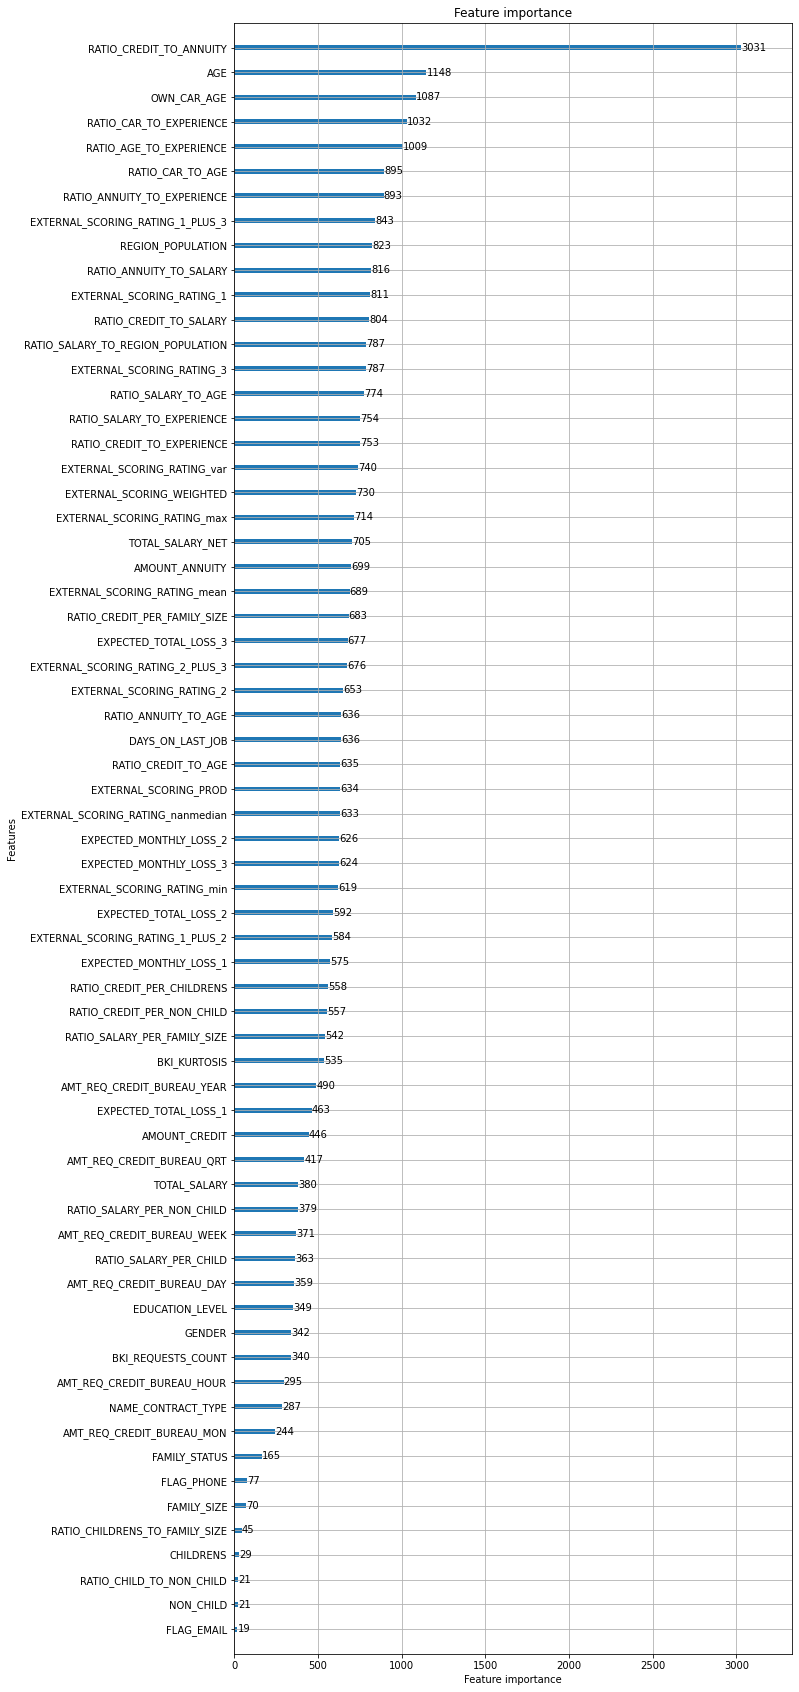

In [63]:
lgb.plot_importance(best_model_lgb,max_num_features=200,figsize=(10,30))

In [64]:
len(best_model_lgb.feature_importances_)

68

Уберем последние 4 признака, которые по существу мало влияют на качество модели и снова обучим модель

In [65]:
train_only_imp_features=train.drop(["CHILDRENS","FLAG_EMAIL","NON_CHILD","RATIO_CHILD_TO_NON_CHILD"],axis=1)

In [66]:
test_only_imp_features=test.drop(["CHILDRENS","FLAG_EMAIL","NON_CHILD","RATIO_CHILD_TO_NON_CHILD"],axis=1)

Оптимизируем параметры модели и снова обучим модель

In [67]:
!pip install bayesian-optimization

You should consider upgrading via the 'C:\Users\Windows\.conda\envs\tf\python.exe -m pip install --upgrade pip' command.


In [68]:
from bayes_opt import BayesianOptimization

In [69]:
def get_train_valid_test_data(data,target):
    x_train, x_valid = train_test_split(
        data, train_size=0.7, shuffle=True, random_state=1
    )
    y_train, y_valid = train_test_split(
        target, train_size=0.7, shuffle=True, random_state=1
    )

    x_valid, x_test = train_test_split(
        x_valid, train_size=0.7, shuffle=True, random_state=27
    )
    y_valid, y_test = train_test_split(
        y_valid, train_size=0.7, shuffle=True, random_state=27
    )

    print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
    print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
    print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
    return x_train, x_valid,x_test, y_train, y_valid,y_test

In [151]:
x_train, x_valid,x_test, y_train, y_valid,y_test=get_train_valid_test_data(train_only_imp_features,target)

x_train.shape = 77065 rows, 64 cols
x_valid.shape = 23119 rows, 64 cols
x_test.shape = 9909 rows, 64 cols


In [273]:
def lgboost_optimize_params(max_depth, colsample_bytree, num_leaves, min_data_in_leaf,
                            min_child_weight):

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'n_estimators': 9000,
        'n_jobs': 7,
        'seed': 27,
        'early_stopping_rounds':500,
        'num_leaves': 57,
        'max_depth': 9,
        'subsample_for_bin': 200000,
        'lambda_l1': 0.436193,
        'lambda_l2': 0.479169,
        'colsample_bytree': 0.508716,
        'min_split_gain': 0.024766,
        'subsample': 0.7,
        'is_unbalance': False,
        'random_state': 27,
        'extra_trees':False,
        'min_data_in_leaf':20,
        'min_child_weight': 0.001,
        'subsample_freq':0
    }
    
    params["max_depth"] = int(max_depth)  
    params["colsample_bytree"] = colsample_bytree
    params["num_leaves"] = int(num_leaves)   
    params["min_data_in_leaf"] = int(min_data_in_leaf)
    params["min_child_weight"] = min_child_weight
       
    
    model = lgb.LGBMClassifier(**params)
    
    model.fit(X=x_train,y=y_train,
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      early_stopping_rounds=500,
                      eval_metric="auc",
                      verbose=200,
                      categorical_feature=categorical)
 
    return roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])

In [254]:
params_search = {
    "max_depth": (6, 10),    
    "colsample_bytree": (0.3, 0.9),
    "num_leaves": (25,100),     
    'min_data_in_leaf': (25,256)
    'min_child_weight':(0.0005,0.05)  
}

optimizer = BayesianOptimization(
    f=lgboost_optimize_params,
    pbounds=params_search,
    random_state=27
)
optimizer.maximize(
    init_points=7, n_iter=20, acq='ei'
)

|   iter    |  target   | colsam... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.796115	valid_1's auc: 0.720958
[400]	training's auc: 0.830393	valid_1's auc: 0.725106
[600]	training's auc: 0.850126	valid_1's auc: 0.725539
[800]	training's auc: 0.868439	valid_1's auc: 0.725713
[1000]	training's auc: 0.884222	valid_1's auc: 0.725898
[1200]	training's auc: 0.896984	valid_1's auc: 0.726256
[1400]	training's auc: 0.907614	valid_1's auc: 0.726232
[1600]	training's auc: 0.915779	valid_1's auc: 0.726208
[1800]	training's auc: 0.922411	valid_1's auc: 0.725517
|  1        |  0.7268   |  0.5554   |  9.258    |  194.9    |  90.1     |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: l

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.75776	valid_1's auc: 0.72063
[400]	training's auc: 0.783986	valid_1's auc: 0.725142
[600]	training's auc: 0.802654	valid_1's auc: 0.726157
[800]	training's auc: 0.819317	valid_1's auc: 0.726076
[1000]	training's auc: 0.8343	valid_1's auc: 0.726252
[1200]	training's auc: 0.848366	valid_1's auc: 0.726177
[1400]	training's auc: 0.862025	valid_1's auc: 0.726219
[1600]	training's auc: 0.874227	valid_1's auc: 0.725639
[1800]	training's auc: 0.884532	valid_1's auc: 0.725632
|  2        |  0.7268   |  0.53     |  9.918    |  231.3    |  40.73    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=229, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=229
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambd

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.790227	valid_1's auc: 0.721091
[400]	training's auc: 0.818971	valid_1's auc: 0.723534
[600]	training's auc: 0.836235	valid_1's auc: 0.724355
[800]	training's auc: 0.851124	valid_1's auc: 0.724072
[1000]	training's auc: 0.865975	valid_1's auc: 0.72391
[1200]	training's auc: 0.878008	valid_1's auc: 0.723873
|  3        |  0.7252   |  0.7451   |  8.653    |  229.9    |  89.35    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.770643	valid_1's auc: 0.719792
[400]	training's auc: 0.803297	valid_1's auc: 0.723376
[600]	training's auc: 0.826976	valid_1's auc: 0.723926
[800]	training's auc: 0.84916	valid_1's auc: 0.72394
[1000]	training's auc: 0.8675	valid_1's auc: 0.723632
[1200]	training's auc: 0.883785	valid_1's auc: 0.723784
[1400]	training's auc: 0.896793	valid_1's auc: 0.722871
|  4        |  0.7244   |  0.7496   |  9.481    |  68.14    |  49.42    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Cur

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.757939	valid_1's auc: 0.719914
[400]	training's auc: 0.785707	valid_1's auc: 0.724667
[600]	training's auc: 0.806751	valid_1's auc: 0.725499
[800]	training's auc: 0.826328	valid_1's auc: 0.724958
[1000]	training's auc: 0.843497	valid_1's auc: 0.724691
[1200]	training's auc: 0.858249	valid_1's auc: 0.724203
|  5        |  0.7257   |  0.5238   |  9.175    |  59.89    |  37.75    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=205, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=205
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.753004	valid_1's auc: 0.720255
[400]	training's auc: 0.775672	valid_1's auc: 0.724597
[600]	training's auc: 0.791936	valid_1's auc: 0.726991
[800]	training's auc: 0.805424	valid_1's auc: 0.727443
[1000]	training's auc: 0.81778	valid_1's auc: 0.727959
[1200]	training's auc: 0.828345	valid_1's auc: 0.727735
[1400]	training's auc: 0.840375	valid_1's auc: 0.727402
|  6        |  0.7282   |  0.3487   |  7.221    |  205.9    |  37.22    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. 

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.781558	valid_1's auc: 0.721578
[400]	training's auc: 0.817055	valid_1's auc: 0.726262
[600]	training's auc: 0.841657	valid_1's auc: 0.72738
[800]	training's auc: 0.861465	valid_1's auc: 0.727376
[1000]	training's auc: 0.878021	valid_1's auc: 0.727823
[1200]	training's auc: 0.892088	valid_1's auc: 0.726901
|  7        |  0.7286   |  0.3424   |  8.804    |  66.81    |  69.92    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.784708	valid_1's auc: 0.719813
[400]	training's auc: 0.820648	valid_1's auc: 0.723007
[600]	training's auc: 0.844307	valid_1's auc: 0.723573
[800]	training's auc: 0.863849	valid_1's auc: 0.724646
[1000]	training's auc: 0.881937	valid_1's auc: 0.724711
[1200]	training's auc: 0.897304	valid_1's auc: 0.724315
[1400]	training's auc: 0.909093	valid_1's auc: 0.724493
|  8        |  0.7251   |  0.6187   |  8.296    |  65.75    |  69.33    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored.

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.797731	valid_1's auc: 0.719778
[400]	training's auc: 0.835716	valid_1's auc: 0.722591
[600]	training's auc: 0.855319	valid_1's auc: 0.722937
[800]	training's auc: 0.873034	valid_1's auc: 0.722726
[1000]	training's auc: 0.889741	valid_1's auc: 0.722758
|  9        |  0.7235   |  0.8351   |  8.17     |  91.58    |  89.19    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.774059	valid_1's auc: 0.720419
[400]	training's auc: 0.807198	valid_1's auc: 0.723711
[600]	training's auc: 0.829993	valid_1's auc: 0.725097
[800]	training's auc: 0.849606	valid_1's auc: 0.725152
[1000]	training's auc: 0.86763	valid_1's auc: 0.724871
|  10       |  0.7256   |  0.6311   |  8.132    |  70.28    |  56.08    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.767114	valid_1's auc: 0.720078
[400]	training's auc: 0.798148	valid_1's auc: 0.724372
[600]	training's auc: 0.821114	valid_1's auc: 0.724802
[800]	training's auc: 0.842018	valid_1's auc: 0.723987
|  11       |  0.7251   |  0.622    |  9.849    |  95.02    |  48.16    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763017	valid_1's auc: 0.720208
[400]	training's auc: 0.788345	valid_1's auc: 0.723889
[600]	training's auc: 0.805775	valid_1's auc: 0.724964
[800]	training's auc: 0.820617	valid_1's auc: 0.725485
[1000]	training's auc: 0.835215	valid_1's auc: 0.725371
[1200]	training's auc: 0.848906	valid_1's auc: 0.725415
[1400]	training's auc: 0.860682	valid_1's auc: 0.724987
|  12       |  0.7257   |  0.4728   |  7.941    |  131.4    |  46.35    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignore

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.794274	valid_1's auc: 0.720786
[400]	training's auc: 0.827112	valid_1's auc: 0.723681
[600]	training's auc: 0.844794	valid_1's auc: 0.72358
[800]	training's auc: 0.861188	valid_1's auc: 0.723383
[1000]	training's auc: 0.87755	valid_1's auc: 0.722622
|  13       |  0.7241   |  0.6533   |  8.622    |  149.8    |  89.32    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.809432	valid_1's auc: 0.720593
[400]	training's auc: 0.855442	valid_1's auc: 0.723526
[600]	training's auc: 0.883021	valid_1's auc: 0.725527
[800]	training's auc: 0.902939	valid_1's auc: 0.726196
[1000]	training's auc: 0.918171	valid_1's auc: 0.725531
[1200]	training's auc: 0.929283	valid_1's auc: 0.725886
|  14       |  0.7264   |  0.4025   |  9.048    |  26.03    |  99.1     |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.759013	valid_1's auc: 0.719675
[400]	training's auc: 0.779519	valid_1's auc: 0.723935
[600]	training's auc: 0.793011	valid_1's auc: 0.724521
[800]	training's auc: 0.80475	valid_1's auc: 0.723941
[1000]	training's auc: 0.815516	valid_1's auc: 0.725018
[1200]	training's auc: 0.825441	valid_1's auc: 0.72474
[1400]	training's auc: 0.835889	valid_1's auc: 0.72511
[1600]	training's auc: 0.845929	valid_1's auc: 0.725072
[1800]	training's auc: 0.855314	valid_1's auc: 0.724367
|  15       |  0.7258   |  0.6698   |  6.851    |  222.3    |  52.26    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.804743	valid_1's auc: 0.719452
[400]	training's auc: 0.846077	valid_1's auc: 0.72196
[600]	training's auc: 0.867492	valid_1's auc: 0.722232
[800]	training's auc: 0.886274	valid_1's auc: 0.722517
[1000]	training's auc: 0.901306	valid_1's auc: 0.721957
|  16       |  0.7227   |  0.8169   |  8.997    |  50.46    |  95.24    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=137, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=137
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.780627	valid_1's auc: 0.720096
[400]	training's auc: 0.810636	valid_1's auc: 0.723338
[600]	training's auc: 0.826236	valid_1's auc: 0.723628
[800]	training's auc: 0.841379	valid_1's auc: 0.723002
|  17       |  0.7244   |  0.7226   |  7.927    |  137.5    |  74.03    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.759283	valid_1's auc: 0.720052
[400]	training's auc: 0.786197	valid_1's auc: 0.724289
[600]	training's auc: 0.806246	valid_1's auc: 0.724246
[800]	training's auc: 0.82397	valid_1's auc: 0.725279
[1000]	training's auc: 0.840566	valid_1's auc: 0.725631
[1200]	training's auc: 0.854927	valid_1's auc: 0.725039
[1400]	training's auc: 0.86829	valid_1's auc: 0.724123
|  18       |  0.7258   |  0.4654   |  7.222    |  40.61    |  40.06    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. C

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.765097	valid_1's auc: 0.719537
[400]	training's auc: 0.790751	valid_1's auc: 0.723208
[600]	training's auc: 0.807253	valid_1's auc: 0.72385
[800]	training's auc: 0.821239	valid_1's auc: 0.724156
[1000]	training's auc: 0.834236	valid_1's auc: 0.724073
[1200]	training's auc: 0.845821	valid_1's auc: 0.724121
[1400]	training's auc: 0.857096	valid_1's auc: 0.72403
|  19       |  0.7247   |  0.593    |  6.113    |  60.08    |  78.69    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=243, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=243
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored.

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.756783	valid_1's auc: 0.720529
[400]	training's auc: 0.777088	valid_1's auc: 0.724032
[600]	training's auc: 0.789214	valid_1's auc: 0.725532
[800]	training's auc: 0.798845	valid_1's auc: 0.725826
[1000]	training's auc: 0.809609	valid_1's auc: 0.725734
[1200]	training's auc: 0.819673	valid_1's auc: 0.726336
[1400]	training's auc: 0.82882	valid_1's auc: 0.726054
[1600]	training's auc: 0.837937	valid_1's auc: 0.726027
[1800]	training's auc: 0.846077	valid_1's auc: 0.726016
[2000]	training's auc: 0.85454	valid_1's auc: 0.725976
|  20       |  0.7266   |  0.4169   |  6.775    |  244.0    |  66.68    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=183, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=183
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.47

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.753987	valid_1's auc: 0.719102
[400]	training's auc: 0.779515	valid_1's auc: 0.724423
[600]	training's auc: 0.798724	valid_1's auc: 0.724085
[800]	training's auc: 0.815154	valid_1's auc: 0.72414
|  21       |  0.7245   |  0.8762   |  9.5      |  183.3    |  34.16    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.744949	valid_1's auc: 0.718912
[400]	training's auc: 0.765893	valid_1's auc: 0.722333
[600]	training's auc: 0.78024	valid_1's auc: 0.723696
[800]	training's auc: 0.792471	valid_1's auc: 0.723529
[1000]	training's auc: 0.80415	valid_1's auc: 0.72333
|  22       |  0.7243   |  0.7486   |  6.824    |  106.4    |  27.39    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.798333	valid_1's auc: 0.720594
[400]	training's auc: 0.831808	valid_1's auc: 0.723858
[600]	training's auc: 0.850464	valid_1's auc: 0.724341
[800]	training's auc: 0.866252	valid_1's auc: 0.72519
[1000]	training's auc: 0.882335	valid_1's auc: 0.72492
[1200]	training's auc: 0.895513	valid_1's auc: 0.725038
|  23       |  0.7258   |  0.5292   |  8.452    |  129.1    |  98.39    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.801874	valid_1's auc: 0.720336
[400]	training's auc: 0.84152	valid_1's auc: 0.72391
[600]	training's auc: 0.864835	valid_1's auc: 0.723894
[800]	training's auc: 0.884167	valid_1's auc: 0.723521
[1000]	training's auc: 0.901553	valid_1's auc: 0.72406
|  24       |  0.7243   |  0.7191   |  9.319    |  107.7    |  92.52    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.765207	valid_1's auc: 0.719435
[400]	training's auc: 0.7913	valid_1's auc: 0.723424
[600]	training's auc: 0.806705	valid_1's auc: 0.723958
[800]	training's auc: 0.820307	valid_1's auc: 0.723292
|  25       |  0.7243   |  0.6876   |  6.687    |  71.07    |  60.71    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.802333	valid_1's auc: 0.718972
[400]	training's auc: 0.837719	valid_1's auc: 0.722027
[600]	training's auc: 0.858348	valid_1's auc: 0.722204
[800]	training's auc: 0.875439	valid_1's auc: 0.722054
[1000]	training's auc: 0.891881	valid_1's auc: 0.722424
[1200]	training's auc: 0.905091	valid_1's auc: 0.722299
[1400]	training's auc: 0.915285	valid_1's auc: 0.720816
|  26       |  0.7231   |  0.8841   |  9.99     |  170.3    |  96.14    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignore

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.782922	valid_1's auc: 0.720959
[400]	training's auc: 0.810267	valid_1's auc: 0.724623
[600]	training's auc: 0.827406	valid_1's auc: 0.725327
[800]	training's auc: 0.841833	valid_1's auc: 0.726003
[1000]	training's auc: 0.855685	valid_1's auc: 0.725749
[1200]	training's auc: 0.869373	valid_1's auc: 0.725723
|  27       |  0.7265   |  0.498    |  7.323    |  127.0    |  87.28    |


In [255]:
optimal_lgb_params = optimizer.max

In [256]:
optimal_lgb_params

{'target': 0.7285736263388486,
 'params': {'colsample_bytree': 0.34238477753119584,
  'max_depth': 8.804284691566153,
  'min_data_in_leaf': 66.80635207218523,
  'num_leaves': 69.9187937784069}}

In [257]:
optimal_lgb_params["params"]["max_depth"]=int(np.round(optimal_lgb_params["params"]["max_depth"]))
optimal_lgb_params["params"]["num_leaves"]=int(np.round(optimal_lgb_params["params"]["num_leaves"]))
optimal_lgb_params["params"]["min_data_in_leaf"]=int(np.round(optimal_lgb_params["params"]["min_data_in_leaf"]))


In [258]:
optimal_lgb_params

{'target': 0.7285736263388486,
 'params': {'colsample_bytree': 0.34238477753119584,
  'max_depth': 9,
  'min_data_in_leaf': 67,
  'num_leaves': 70}}

In [259]:
lgbm_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'n_estimators': 9000,
        'n_jobs': 7,
        'seed': 27,
        'early_stopping_rounds':500,
        'num_leaves': 57,
        'max_depth': 9,
        'subsample_for_bin': 200000,
        'lambda_l1': 0.436193,
        'lambda_l2': 0.479169,
        'colsample_bytree': 0.508716,
        'min_split_gain': 0.024766,
        'subsample': 0.7,
        'is_unbalance': False,
        'random_state': 27,
        'extra_trees':False,
        'min_data_in_leaf':20,
        'min_child_weight': 0.001,
        'subsample_freq':0
    
 }

In [260]:
for optimal_lgb_param_name in optimal_lgb_params["params"]:
    lgbm_params[optimal_lgb_param_name]=optimal_lgb_params["params"][optimal_lgb_param_name]
    

In [261]:
lgbm_params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'auc',
 'learning_rate': 0.01,
 'n_estimators': 9000,
 'n_jobs': 7,
 'seed': 27,
 'early_stopping_rounds': 500,
 'num_leaves': 70,
 'max_depth': 9,
 'subsample_for_bin': 200000,
 'lambda_l1': 0.436193,
 'lambda_l2': 0.479169,
 'colsample_bytree': 0.34238477753119584,
 'min_split_gain': 0.024766,
 'subsample': 0.7,
 'is_unbalance': False,
 'random_state': 27,
 'extra_trees': False,
 'min_data_in_leaf': 67,
 'min_child_weight': 0.001,
 'subsample_freq': 0}

Используется BayesianOptimization

In [262]:
model = lgb.LGBMClassifier(**lgbm_params)

In [263]:
#model,test_prediction=get_samples_hold_out_validation(lgbm_params,train,target,[0.7,0.2,0.1],'LGBM', categorical)
#cv_strategy = KFold(n_splits=20, random_state=42,shuffle=True)
#cv_strategy = StratifiedShuffleSplit(n_splits=20, random_state=27, train_size=0.7)
cv_strategy = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train_only_imp_features, target, model, categorical, metric=roc_auc_score,cv_strategy=cv_strategy
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.768946	valid_1's auc: 0.713565
[400]	training's auc: 0.80216	valid_1's auc: 0.720543
[600]	training's auc: 0.828857	valid_1's auc: 0.723278
[800]	training's auc: 0.84929	valid_1's auc: 0.723693
[1000]	training's auc: 0.866238	valid_1's auc: 0.724008
[1200]	training's auc: 0.881614	valid_1's auc: 0.723129
Fold: 1, train-observations = 104588, valid-observations = 5505
train-score = 0.8533, valid-score = 0.7247
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_sto

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769396	valid_1's auc: 0.707464
[400]	training's auc: 0.802504	valid_1's auc: 0.717752
[600]	training's auc: 0.828616	valid_1's auc: 0.721124
[800]	training's auc: 0.848841	valid_1's auc: 0.722019
[1000]	training's auc: 0.865579	valid_1's auc: 0.720323
[1200]	training's auc: 0.881153	valid_1's auc: 0.720044
Fold: 2, train-observations = 104588, valid-observations = 5505
train-score = 0.8527, valid-score = 0.7224
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_s

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769391	valid_1's auc: 0.728514
[400]	training's auc: 0.802538	valid_1's auc: 0.730383
[600]	training's auc: 0.827406	valid_1's auc: 0.730079
[800]	training's auc: 0.847911	valid_1's auc: 0.731195
[1000]	training's auc: 0.865473	valid_1's auc: 0.731888
[1200]	training's auc: 0.880741	valid_1's auc: 0.730913
[1400]	training's auc: 0.893327	valid_1's auc: 0.73109
[1600]	training's auc: 0.903923	valid_1's auc: 0.730421
[1800]	training's auc: 0.912887	valid_1's auc: 0.728417
Fold: 3, train-observations = 104588, valid-observations = 5505
train-score = 0.8903, valid-score = 0.7325
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 wil

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.768086	valid_1's auc: 0.723752
[400]	training's auc: 0.80217	valid_1's auc: 0.729438
[600]	training's auc: 0.827943	valid_1's auc: 0.73182
[800]	training's auc: 0.848476	valid_1's auc: 0.730906
[1000]	training's auc: 0.866184	valid_1's auc: 0.732
Fold: 4, train-observations = 104588, valid-observations = 5505
train-score = 0.8213, valid-score = 0.7323
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769039	valid_1's auc: 0.719771
[400]	training's auc: 0.803372	valid_1's auc: 0.72797
[600]	training's auc: 0.829403	valid_1's auc: 0.730056
[800]	training's auc: 0.851184	valid_1's auc: 0.73013
[1000]	training's auc: 0.868213	valid_1's auc: 0.730759
[1200]	training's auc: 0.882323	valid_1's auc: 0.731041
[1400]	training's auc: 0.894082	valid_1's auc: 0.729526
Fold: 5, train-observations = 104588, valid-observations = 5505
train-score = 0.8651, valid-score = 0.7313
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopp

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769102	valid_1's auc: 0.721448
[400]	training's auc: 0.801928	valid_1's auc: 0.723957
[600]	training's auc: 0.827523	valid_1's auc: 0.725634
[800]	training's auc: 0.847435	valid_1's auc: 0.724522
[1000]	training's auc: 0.864451	valid_1's auc: 0.724672
Fold: 6, train-observations = 104588, valid-observations = 5505
train-score = 0.8368, valid-score = 0.7266
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.768489	valid_1's auc: 0.726698
[400]	training's auc: 0.802195	valid_1's auc: 0.730929
[600]	training's auc: 0.827146	valid_1's auc: 0.735197
[800]	training's auc: 0.847866	valid_1's auc: 0.738065
[1000]	training's auc: 0.865047	valid_1's auc: 0.739219
[1200]	training's auc: 0.87923	valid_1's auc: 0.741547
[1400]	training's auc: 0.892193	valid_1's auc: 0.73975
[1600]	training's auc: 0.90288	valid_1's auc: 0.738972
Fold: 7, train-observations = 104588, valid-observations = 5505
train-score = 0.8785, valid-score = 0.7418
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM]

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.767688	valid_1's auc: 0.735111
[400]	training's auc: 0.801501	valid_1's auc: 0.74173
[600]	training's auc: 0.827575	valid_1's auc: 0.742723
[800]	training's auc: 0.847378	valid_1's auc: 0.742612
[1000]	training's auc: 0.864288	valid_1's auc: 0.742609
[1200]	training's auc: 0.878308	valid_1's auc: 0.742562
[1400]	training's auc: 0.891525	valid_1's auc: 0.741601
[1600]	training's auc: 0.902078	valid_1's auc: 0.741117
Fold: 8, train-observations = 104588, valid-observations = 5505
train-score = 0.8736, valid-score = 0.7443
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGB

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769081	valid_1's auc: 0.721172
[400]	training's auc: 0.801209	valid_1's auc: 0.726952
[600]	training's auc: 0.826535	valid_1's auc: 0.732592
[800]	training's auc: 0.84706	valid_1's auc: 0.730898
[1000]	training's auc: 0.863487	valid_1's auc: 0.730548
Fold: 9, train-observations = 104588, valid-observations = 5505
train-score = 0.8265, valid-score = 0.7326
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.768362	valid_1's auc: 0.73059
[400]	training's auc: 0.802309	valid_1's auc: 0.736534
[600]	training's auc: 0.828625	valid_1's auc: 0.739566
[800]	training's auc: 0.847887	valid_1's auc: 0.739983
[1000]	training's auc: 0.86451	valid_1's auc: 0.740389
[1200]	training's auc: 0.87847	valid_1's auc: 0.739792
[1400]	training's auc: 0.891564	valid_1's auc: 0.740021
Fold: 10, train-observations = 104588, valid-observations = 5505
train-score = 0.8648, valid-score = 0.7409
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopp

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769538	valid_1's auc: 0.720349
[400]	training's auc: 0.802958	valid_1's auc: 0.72605
[600]	training's auc: 0.828718	valid_1's auc: 0.72639
[800]	training's auc: 0.848944	valid_1's auc: 0.726216
[1000]	training's auc: 0.865498	valid_1's auc: 0.724678
Fold: 11, train-observations = 104588, valid-observations = 5505
train-score = 0.819, valid-score = 0.728
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769212	valid_1's auc: 0.719901
[400]	training's auc: 0.802931	valid_1's auc: 0.7242
[600]	training's auc: 0.828784	valid_1's auc: 0.723477
[800]	training's auc: 0.847896	valid_1's auc: 0.723578
Fold: 12, train-observations = 104588, valid-observations = 5505
train-score = 0.8158, valid-score = 0.7262
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.768245	valid_1's auc: 0.732166
[400]	training's auc: 0.801818	valid_1's auc: 0.737601
[600]	training's auc: 0.826689	valid_1's auc: 0.739101
[800]	training's auc: 0.84674	valid_1's auc: 0.73855
[1000]	training's auc: 0.863775	valid_1's auc: 0.738417
Fold: 13, train-observations = 104588, valid-observations = 5505
train-score = 0.831, valid-score = 0.7398
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769272	valid_1's auc: 0.706492
[400]	training's auc: 0.801982	valid_1's auc: 0.712197
[600]	training's auc: 0.827664	valid_1's auc: 0.716358
[800]	training's auc: 0.847298	valid_1's auc: 0.717576
[1000]	training's auc: 0.864614	valid_1's auc: 0.717289
[1200]	training's auc: 0.880487	valid_1's auc: 0.718355
[1400]	training's auc: 0.894468	valid_1's auc: 0.716114
[1600]	training's auc: 0.904467	valid_1's auc: 0.71623
Fold: 14, train-observations = 104589, valid-observations = 5504
train-score = 0.8864, valid-score = 0.719
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.769616	valid_1's auc: 0.718687
[400]	training's auc: 0.802518	valid_1's auc: 0.728204
[600]	training's auc: 0.828182	valid_1's auc: 0.729168
[800]	training's auc: 0.84862	valid_1's auc: 0.728328
[1000]	training's auc: 0.865783	valid_1's auc: 0.727711
Fold: 15, train-observations = 104589, valid-observations = 5504
train-score = 0.8236, valid-score = 0.7297
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769773	valid_1's auc: 0.694177
[400]	training's auc: 0.803357	valid_1's auc: 0.700969
[600]	training's auc: 0.829808	valid_1's auc: 0.704456
[800]	training's auc: 0.849256	valid_1's auc: 0.706144
[1000]	training's auc: 0.866081	valid_1's auc: 0.706513
[1200]	training's auc: 0.880644	valid_1's auc: 0.705322
[1400]	training's auc: 0.893542	valid_1's auc: 0.704618
Fold: 16, train-observations = 104589, valid-observations = 5504
train-score = 0.8607, valid-score = 0.7067
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.767963	valid_1's auc: 0.738527
[400]	training's auc: 0.801622	valid_1's auc: 0.74665
[600]	training's auc: 0.827545	valid_1's auc: 0.752
[800]	training's auc: 0.847661	valid_1's auc: 0.753937
[1000]	training's auc: 0.864826	valid_1's auc: 0.755204
[1200]	training's auc: 0.880591	valid_1's auc: 0.754641
[1400]	training's auc: 0.893667	valid_1's auc: 0.754293
Fold: 17, train-observations = 104589, valid-observations = 5504
train-score = 0.871, valid-score = 0.7558
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.768716	valid_1's auc: 0.731609
[400]	training's auc: 0.802771	valid_1's auc: 0.738292
[600]	training's auc: 0.828015	valid_1's auc: 0.739081
[800]	training's auc: 0.849437	valid_1's auc: 0.739628
[1000]	training's auc: 0.866875	valid_1's auc: 0.740906
[1200]	training's auc: 0.88285	valid_1's auc: 0.739924
[1400]	training's auc: 0.894825	valid_1's auc: 0.737133
Fold: 18, train-observations = 104589, valid-observations = 5504
train-score = 0.8672, valid-score = 0.7415
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_sto

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.769943	valid_1's auc: 0.701767
[400]	training's auc: 0.803694	valid_1's auc: 0.70872
[600]	training's auc: 0.82925	valid_1's auc: 0.710714
[800]	training's auc: 0.848982	valid_1's auc: 0.713312
[1000]	training's auc: 0.866222	valid_1's auc: 0.712303
[1200]	training's auc: 0.88118	valid_1's auc: 0.713347
Fold: 19, train-observations = 104589, valid-observations = 5504
train-score = 0.8578, valid-score = 0.7139
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_sto

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.768274	valid_1's auc: 0.726522
[400]	training's auc: 0.802128	valid_1's auc: 0.732899
[600]	training's auc: 0.8283	valid_1's auc: 0.73556
[800]	training's auc: 0.848967	valid_1's auc: 0.736759
[1000]	training's auc: 0.865426	valid_1's auc: 0.73785
[1200]	training's auc: 0.879974	valid_1's auc: 0.73705
[1400]	training's auc: 0.892753	valid_1's auc: 0.735296
Fold: 20, train-observations = 104589, valid-observations = 5504
train-score = 0.8638, valid-score = 0.7383
CV-results train: 0.853 +/- 0.023
CV-results valid: 0.7314 +/- 0.011
OOF-score = 0.8577


In [266]:
fold_number_max_score = np.argmax(fold_valid_scores)
print("max of fold_valid_scores=",np.max(fold_valid_scores))
best_model_lgb=estimators[fold_number_max_score]
test_predict_target=best_model_lgb.predict_proba(test_only_imp_features)[:,1]  

max of fold_valid_scores= 0.7557504591883194


In [267]:
test_predict_target = pd.DataFrame(data = test_predict_target, columns = ["TARGET"], index = test_id.index.copy())
predicted_test = pd.merge(test_id, test_predict_target, how = 'left', left_index = True, right_index = True)


In [268]:
predicted_test_finish = predicted_test.drop_duplicates('APPLICATION_NUMBER', keep='last')
predicted_test_finish

,APPLICATION_NUMBER,TARGET
110093,123724268,0.051618
110094,123456549,0.205129
110095,123428178,0.156043
110096,123619984,0.084627
110097,123671104,0.016538
...,...,...
275229,123487967,0.084627
275230,123536402,0.082711
275231,123718238,0.084627
275232,123631557,0.021895


In [269]:
predicted_test_finish.to_csv("UkladnikovA_4_submit.csv",columns=['APPLICATION_NUMBER','TARGET'],index=False)

In [270]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

строим доверительный интервал на тесте

In [271]:
y_predicted=best_model_lgb.predict_proba(x_test)[:,1] 

In [272]:
scores = create_bootstrap_metrics(y_test, y_predicted, roc_auc_score)

calculate_confidence_interval(scores)

(0.8382820909881499, 0.8624674425956151)